In [1]:
import cv2
import numpy as np
from CDA.dataset_reader import read_dataset
from CDA.CNN_denoiser import CNN_denoiser
import matplotlib.pyplot as plt
import os
import imageio
from PIL import Image

2023-11-16 16:32:26.789491: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 16:32:32.016287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 16:32:32.024013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 16:32:48.229411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found, using CPU')
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found, using CPU


2023-11-16 16:33:29.309322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 16:33:29.309584: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
def add_noise(pure, pure_val, pure_test, noise_mean, noise_std, noise_prop):
    noise = np.random.normal(noise_mean, noise_std, pure.shape)  # np.random.poisson(1, pure.shape)
    noise_test = np.random.normal(noise_mean, noise_std, pure_test.shape) # np.random.poisson(1, pure_test.shape)
    noise_val = np.random.normal(noise_mean, noise_std, pure_val.shape) 
    noisy_input = pure + noise_prop * noise
    noisy_input_test = pure_test + noise_prop * noise_test
    noisy_input_val = pure_val + noise_prop * noise_val
    return noisy_input, noisy_input_val, noisy_input_test

In [7]:
batch_size = 10

train_dir = "./denoising-pneumonia//chest_xray/train"
val_dir = "./denoising-pneumonia/chest_xray/val"
test_dir = "./denoising-pneumonia/chest_xray/test"


In [8]:
train_input = read_dataset(train_dir, img_height=224, img_width=224)
val_input = read_dataset(val_dir, img_height=224, img_width=224)
test_input = read_dataset(test_dir, img_height=224, img_width=224)

In [75]:
'''

# Assuming val_input is a NumPy array with shape (16, 224, 224)
for i in range(val_input.shape[0]):
    # Display the image
    image = val_input[i, :, :]

    
    plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.title(f"Image {i + 1}")
    plt.show()

'''

'\n\n# Assuming val_input is a NumPy array with shape (16, 224, 224)\nfor i in range(val_input.shape[0]):\n    # Display the image\n    image = val_input[i, :, :]\n\n    \n    plt.imshow(image, cmap=\'gray\')  # Use \'gray\' colormap for grayscale images\n    plt.title(f"Image {i + 1}")\n    plt.show()\n\n'

In [9]:
# Parse numbers as floats
train_input = train_input.astype('float32')
val_input = val_input.astype('float32')
test_input = test_input.astype('float32')

# Normalize data
train_input = train_input / 255
val_input = val_input / 255
test_input = test_input / 255


pure = train_input
pure_val = val_input
pure_test = test_input

noisy_input, noisy_input_val, noisy_input_test = add_noise(pure, pure_val, pure_test, noise_mean=0, noise_std=1, noise_prop=0.1)

In [11]:
# Create the model
cnn_denoiser = CNN_denoiser(batch_size=batch_size, nu_epochs=15, validation_split=0.2, img_height=224, img_width=224)

print("[LOG] Training and evaluating model...")
# Train the model and save the history
history = cnn_denoiser.train(noisy_input, pure, save=True, verbosity=1)

# Evaluate the model on the validation set
cnn_denoiser.evaluate(noisy_input_val, pure_val)

# Make predictions on a test set
samples = noisy_input_test[:]
print("[LOG] Training and model evaluation completed\n[LOG] Denoising images test set...")
denoised_images = cnn_denoiser.predict(samples)

2023-11-16 16:34:35.696322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 16:34:35.696562: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 up_sampling2d (UpSampling2  (None, 112, 112, 128)     0

/home/branislava.jankovic/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 - 0s - loss: 0.5398 - accuracy: 0.0661 - 348ms/epoch - 348ms/step
[EVALUATION] Test loss: 0.5398382544517517
[EVALUATION] Test accuracy: 0.06614840030670166
[LOG] Training and model evaluation completed
[LOG] Denoising images test set...
20/20 [==============================] - 13s 637ms/step


In [12]:
# Access the training history
loss_values = history.history['loss']
accuracy_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_accuracy_values = history.history['val_accuracy']

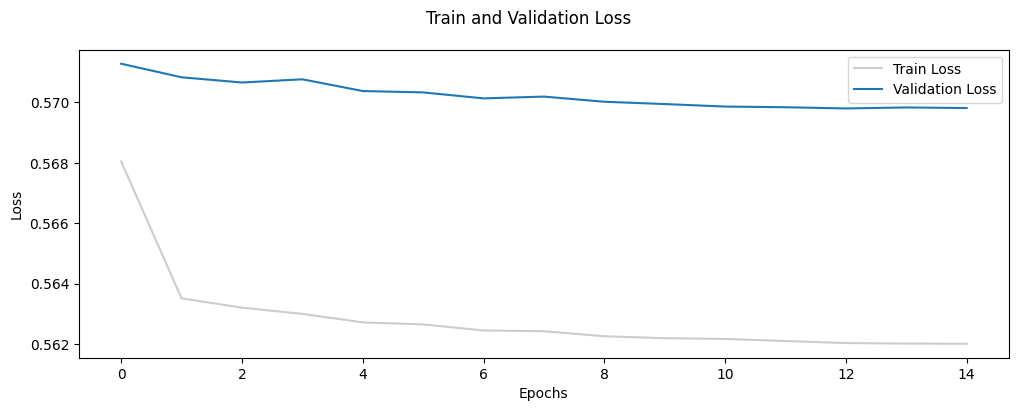

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Loss")
ax.plot(
    loss_values,
    alpha=0.2,
    label="Train Loss",
    color="black",
)
ax.plot(val_loss_values, label="Validation Loss")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
fig.savefig("Train_and_Validation_Loss_224")

_ = ax.legend()

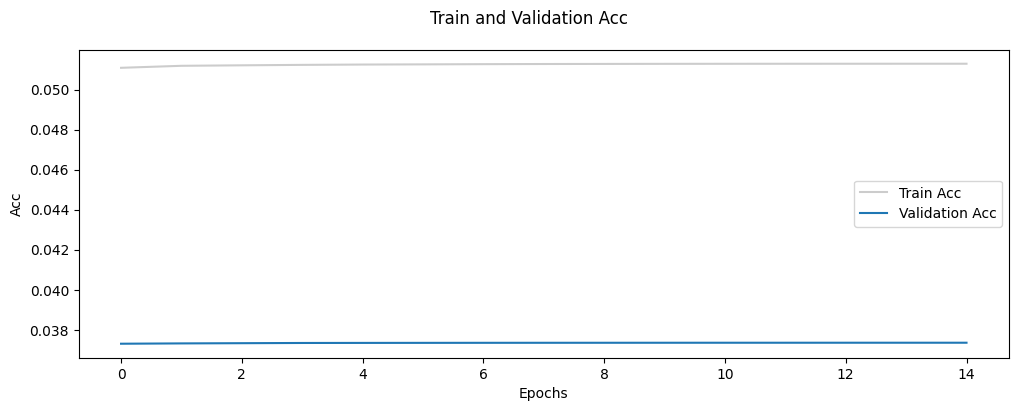

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Acc")
ax.plot(
    accuracy_values,
    alpha=0.2,
    label="Train Acc",
    color="black",
)
ax.plot(val_accuracy_values, label="Validation Acc")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Acc")
fig.savefig("Train_and_Validation_Acc_224")

_ = ax.legend()

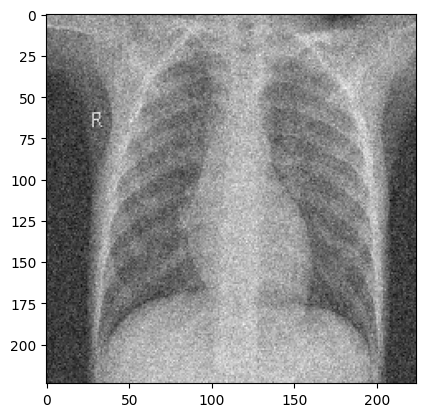

In [15]:
plt.imshow(noisy_input_test[0], plt.cm.gray)

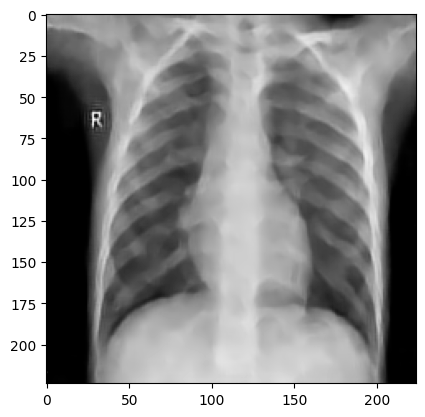

In [16]:
plt.imshow(denoised_images[0], plt.cm.gray)

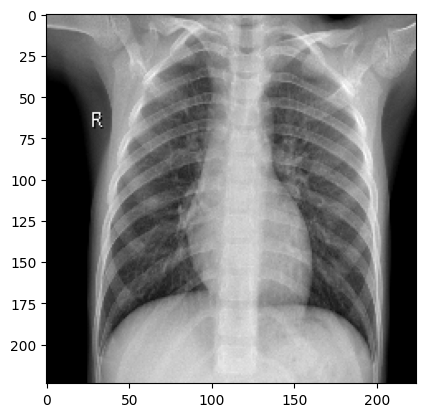

In [17]:
plt.imshow(pure_test[0], plt.cm.gray)

#########################################################################################################################

In [18]:
train_dir0 = "./denoising-pneumonia/chest_xray/train/NORMAL"
train_dir1 = "./denoising-pneumonia/chest_xray/train/PNEUMONIA"

val_dir0 = "./denoising-pneumonia/chest_xray/val/NORMAL"
val_dir1 = "./denoising-pneumonia/chest_xray/val/PNEUMONIA"

test_dir0 = "./denoising-pneumonia/chest_xray/test/NORMAL"
test_dir1 = "./denoising-pneumonia/chest_xray/test/PNEUMONIA"

In [19]:
def kalils_read_dataset(path=None, img_width=64, img_height=64):
    try:
        images = []
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (img_width, img_height))
                images.append(img)

        return np.array(images)
    except Exception as e:
        print(f"Error has occurred during data loading: {e}")



In [20]:
train_input0 = kalils_read_dataset(train_dir0, img_height=224, img_width=224)
train_input1 = kalils_read_dataset(train_dir1, img_height=224, img_width=224)

val_input0 = kalils_read_dataset(val_dir0, img_height=224, img_width=224)
val_input1 = kalils_read_dataset(val_dir1, img_height=224, img_width=224)

test_input0 = kalils_read_dataset(test_dir0, img_height=224, img_width=224)
test_input1 = kalils_read_dataset(test_dir1, img_height=224, img_width=224)

In [21]:
# Parse numbers as floats
train_input0 = train_input0.astype('float32')
train_input1.astype('float32')

val_input0 = val_input0.astype('float32')
val_input1 = val_input1.astype('float32')

test_input0 = test_input0.astype('float32')
test_input1 = test_input1.astype('float32')


# Normalize data
train_input0 = train_input0 / 255
train_input1 = train_input1 / 255

val_input0 = val_input0 / 255
val_input1 = val_input1 / 255

test_input0 = test_input0 / 255
test_input1 = test_input1 / 255

In [22]:
print(train_input0.shape)
print(val_input0.shape)
print(test_input0.shape)

print(train_input1.shape)
print(val_input1.shape)
print(test_input1.shape)

(1341, 224, 224)
(8, 224, 224)
(234, 224, 224)
(3875, 224, 224)
(8, 224, 224)
(390, 224, 224)


In [23]:
denoised_train_input0 = cnn_denoiser.predict(train_input0)
denoised_val_input0 = cnn_denoiser.predict(val_input0)
denoised_ttest_input0 = cnn_denoiser.predict(test_input0)

denoised_train_input1 = cnn_denoiser.predict(train_input1)
denoised_val_input1 = cnn_denoiser.predict(val_input1)
denoised_ttest_input1 = cnn_denoiser.predict(test_input1)

13/13 [==============================] - 9s 654ms/step


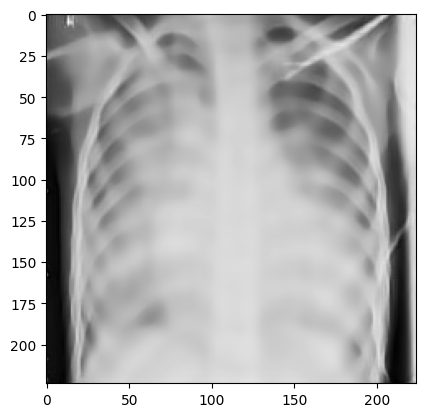

In [24]:
plt.imshow(denoised_train_input1[0], plt.cm.gray)

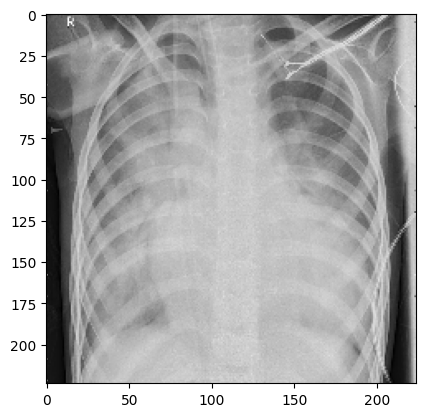

In [25]:
plt.imshow(train_input1[0], plt.cm.gray)

In [26]:
# Function to save all the images
def save_images(image_list, directory, base_filename):
    for i, img in enumerate(image_list):
        # Ensure the image has 3 channels
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = (img * 255).astype('uint8')  # Scale values to 0-255
            img = np.stack((img,) * 3, axis=-1)

        # Convert NumPy array to PIL Image
        pil_img = Image.fromarray(img)

        # Save the image
        pil_img.save(f'{directory}/{base_filename}_{i}.png')

In [27]:
# Call the function for each set of images
save_images(denoised_train_input0, "./denoising-pneumonia/denoised_chest_xray/train/NORMAL", 'denoised_train_input')
save_images(denoised_train_input1, "./denoising-pneumonia/denoised_chest_xray/train/PNEUMONIA", 'denoised_train_input')

save_images(denoised_val_input0, './denoising-pneumonia/denoised_chest_xray/val/NORMAL', 'denoised_val_input')
save_images(denoised_val_input1, './denoising-pneumonia/denoised_chest_xray/val/PNEUMONIA', 'denoised_val_input')

save_images(denoised_ttest_input0, './denoising-pneumonia/denoised_chest_xray/test/NORMAL', 'denoised_test_input')
save_images(denoised_ttest_input1, './denoising-pneumonia/denoised_chest_xray/test/PNEUMONIA', 'denoised_test_input')